<a href="https://colab.research.google.com/github/davione112/HateSpeechDetection/blob/main/Hate_speech_detection_PhoBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
pip install transformers==4.3.0

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 39.8 MB/s 
     |████████████████████████████████| 3.3 MB 21.5 MB/s 


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [4]:
%cd /content/drive/MyDrive/hate_speech_detection

/content/drive/.shortcut-targets-by-id/15esFt6mWnsxUBQ_vxIcTDi0kv6Nx3Brk/hate_speech_detection


In [5]:
train = pd.read_excel("preprocessed_data/train.xlsx")
dev= pd.read_excel("preprocessed_data/dev.xlsx")
test= pd.read_excel("preprocessed_data/test.xlsx")

In [6]:
X_train = train['free_text']
y_train = train['label_id'].values

X_dev = dev['free_text']
y_dev = dev['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values

In [7]:
X_train = X_train.fillna('NaN')
X_dev = X_dev.fillna('NaN')
X_test = X_test.fillna('NaN')

# PhoBERT

In [ ]:
# PhoBERT
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

import seaborn as sn
import matplotlib.pyplot as plt
  
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base",use_fast=False)

import torch

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(X_dev.tolist(), truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, y_train)
dev_dataset = BuildDataset(dev_encodings, y_dev)
test_dataset = BuildDataset(test_encodings, y_test)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/HSD/transformer_model/phobert-v3/',          
    num_train_epochs=2,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

trainer.train()
trainer.save_model("/content/drive/MyDrive/HSD/transformer_model/phobert-v3/")

Step,Training Loss
500,0.557700
1000,0.413500
1500,0.363100
2000,0.312000
2500,0.312100


[[4827   90  123]
 [ 187  193   55]
 [ 229   62  404]]
F1 - micro: 0.8790923824959481
F1 - macro: 0.6888119477297653


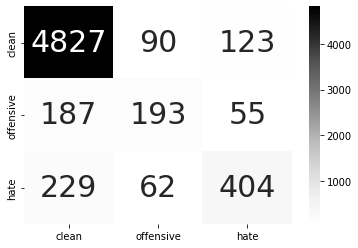

In [ ]:
y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = y_test

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

# Load model and predict

In [13]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
import torch
import seaborn as sn
import matplotlib.pyplot as plt

In [14]:
### LOAD MODEL
pretrained_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/HSD/transformer_model/phobert-v3/")
model = Trainer(model=pretrained_model)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base",use_fast=False)

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/895k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [15]:
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100)
test_dataset = BuildDataset(test_encodings, y_test)

[[4828   96  116]
 [ 187  190   58]
 [ 221   63  411]]
              precision    recall  f1-score   support

           0     0.9221    0.9579    0.9397      5040
           1     0.5444    0.4368    0.4847       435
           2     0.7026    0.5914    0.6422       695

    accuracy                         0.8799      6170
   macro avg     0.7230    0.6620    0.6888      6170
weighted avg     0.8707    0.8799    0.8741      6170

F1 - micro: 0.879902755267423
F1 - macro: 0.6888488723145935


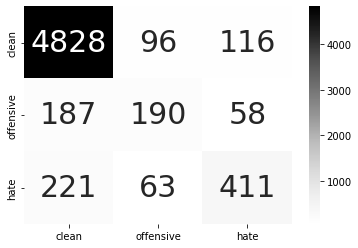

In [16]:
y_pred_classify = model.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
y_true = y_test

cf1 = confusion_matrix(y_true, y_pred)
print(cf1)
print(classification_report(y_true,y_pred,digits=4))

evaluation = f1_score(y_true, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(y_true, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

# Show out the confusion matrix
df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

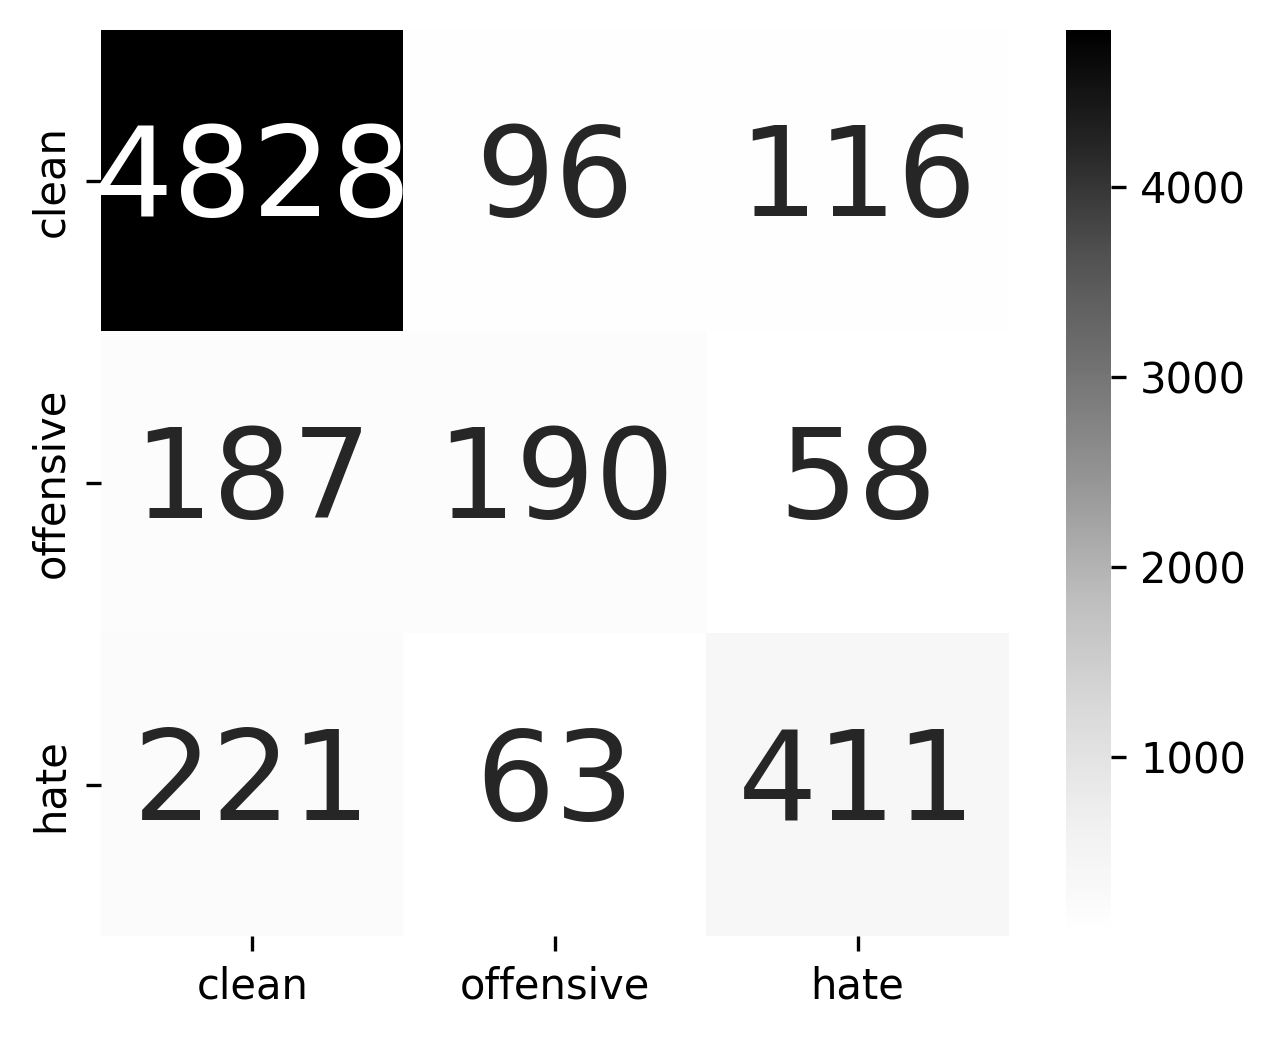

In [36]:
plt.figure(figsize=(4.88,4),dpi=300)
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
# Predict custome text
sentence = 'từ từ cái loz, đánh chek mẹ nó'
end = tokenizer([sentence],truncation=True, padding=True, max_length=100)
test_dataset = BuildDataset(end, [0])
pred = model.predict(test_dataset)
print('Label: ',np.argmax(pred.predictions, axis=-1))